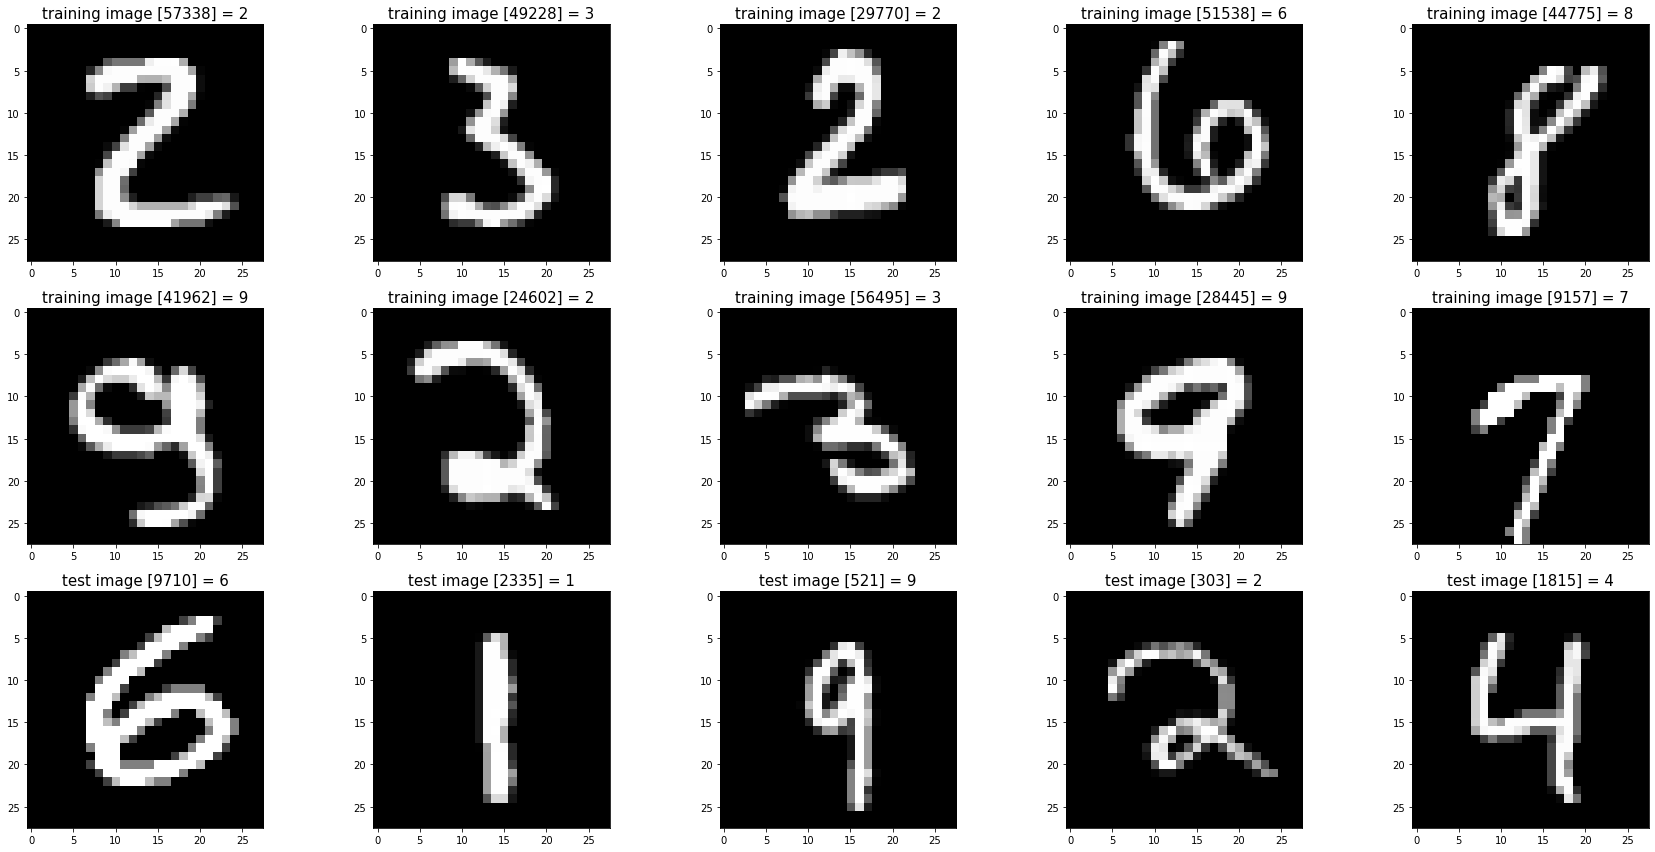

In [1]:
from data_reading import x_train, y_train,x_test, y_test
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import logging
from tensorflow import get_logger

In [2]:

def create_cnn_model(input_shape=(28, 28, 1), num_conv_layers=2, num_filters_per_layer=[32, 64], num_dense_units=128, dropout_rate=0.5):
    model = Sequential()
    
    # Add the convolutional layers
    for i in range(num_conv_layers):
        # For the first layer, specify the input shape
        if i == 0:
            model.add(Conv2D(num_filters_per_layer[i], kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(num_filters_per_layer[i], kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Add a dense layer
    model.add(Dense(num_dense_units, activation='relu'))
    
    # Add dropout for regularization
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [3]:
x_test,x_train = np.array(x_test),np.array(x_train)
y_test,y_train = np.array(y_test),np.array(y_train)

# Reshape the data if necessary
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


In [4]:
model = create_cnn_model(input_shape=(28, 28, 1), num_conv_layers=2, num_filters_per_layer=[32, 64], num_dense_units=128, dropout_rate=0.5)


In [5]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
750/750 [==============================] - 13s 17ms/step - loss: 0.2743 - accuracy: 0.9160 - val_loss: 0.0647 - val_accuracy: 0.9799
Epoch 2/10
750/750 [==============================] - 23s 31ms/step - loss: 0.0921 - accuracy: 0.9723 - val_loss: 0.0563 - val_accuracy: 0.9830
Epoch 3/10
750/750 [==============================] - 12s 16ms/step - loss: 0.0698 - accuracy: 0.9785 - val_loss: 0.0401 - val_accuracy: 0.9875
Epoch 4/10
750/750 [==============================] - 11s 15ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.0393 - val_accuracy: 0.9883
Epoch 5/10
750/750 [==============================] - 10s 13ms/step - loss: 0.0471 - accuracy: 0.9849 - val_loss: 0.0462 - val_accuracy: 0.9876
Epoch 6/10
750/750 [==============================] - 10s 14ms/step - loss: 0.0415 - accuracy: 0.9871 - val_loss: 0.0369 - val_accuracy: 0.9892
Epoch 7/10
750/750 [==============================] - 11s 14ms/step - loss: 0.0351 - accuracy: 0.9891 - val_loss: 0.0373 - val_accuracy:

In [6]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


313/313 [==============================] - 2s 7ms/step - loss: 0.0314 - accuracy: 0.9905
Test Accuracy: 99.05%


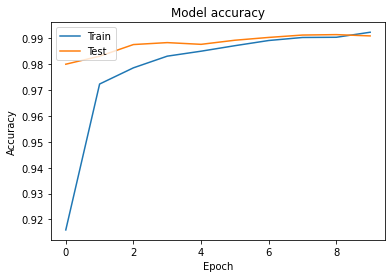

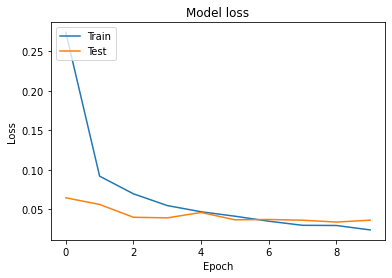

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
